In [208]:
import pandas as pd
import numpy as np
import cufflinks as cf
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


from boruta import BorutaPy

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
                                    train_test_split, 
                                    GridSearchCV, 
                                    TimeSeriesSplit, 
                                    cross_val_score,
                                    RandomizedSearchCV
                                    )
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_score, recall_score, fbeta_score, make_scorer,
                            roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [192]:
def parkinson(price_data, window=30, day_count=252):
    log_hl = np.log(price_data['High']/price_data['Low'])
    sum_log_hl_sq = log_hl.rolling(window).apply(lambda x: np.sum(np.square(x)), raw=True)    
    volatility = sqrt(day_count) * np.sqrt((1 / (4 * np.log(2))) * (1 / window) * sum_log_hl_sq)
    return volatility

def rodgers_satchell(price_data, window=30, day_count=252):
    log_hc = np.log(price_data['High'] / price_data['Close'])
    log_ho = np.log(price_data['High'] / price_data['Open'])
    log_lc = np.log(price_data['Low'] / price_data['Close'])
    log_lo = np.log(price_data['Low'] / price_data['Open'])
    sum_prod = (log_hc * log_ho + log_lc * log_lo).rolling(window).sum()
    volatility = sqrt(day_count) * np.sqrt((1 / (window)) * sum_prod)
    return volatility

def garman_klass(price_data, window=30, day_count=252):
    log_hl = np.log(price_data['High']/price_data['Low'])
    log_ctc = np.log(price_data['Close']/price_data['Close'].shift(1))
    sum_log_hl_sq = log_hl.rolling(window).apply(lambda x: np.sum(np.square(x)), raw=True)
    sum_log_ctc_sq = log_ctc.rolling(window).apply(lambda x: np.sum(np.square(x)), raw=True)
    volatility = sqrt(day_count) * np.sqrt((1 / (window)) * (0.5 * sum_log_hl_sq - (2 * np.log(2) - 1) *
                                                            sum_log_ctc_sq))
    return volatility

def yang_zhang(price_data, window=30, day_count=252):
    log_olc = np.log(price_data['Open']/price_data['Close'].shift(1))
    log_clo = np.log(price_data['Close']/price_data['Open'].shift(1))
    sigma_o_sq = (1 / (window - 1)) * log_olc.rolling(window).apply(lambda x: np.sum(np.square(x)), raw=True)
    sigma_c_sq = (1 / (window - 1)) * log_clo.rolling(window).apply(lambda x: np.sum(np.square(x)), raw=True)
    sigma_rs_sq = (window / (day_count * (window - 1))) * \
    rodgers_satchell(price_data, window=window, day_count=day_count) ** 2
    k = 0.34 / (1 + (window + 1) / (window - 1))
    volatility = sqrt(day_count) * np.sqrt(sigma_o_sq  + k * sigma_c_sq + (1 - k) * sigma_rs_sq)
    return volatility

def rolling_z(price_data, window=30, standardize=True):
    if standardize:
        z_scores = (price_data - price_data.rolling(window, min_periods=window).mean()) \
            / price_data.rolling(window, min_periods=window).std()
    else:
        z_scores = price_data / price_data.rolling(window, min_periods=window).std()
    return z_scores

In [250]:
ccies = ['EUR', 'JPY', 'GBP', 'CAD', 'AUD', 'NZD', 'CHF']
strong = ['EUR', 'GBP', 'AUD', 'NZD']

df_spot = pd.read_csv('FXSpot.csv', index_col=0, parse_dates=True).sort_index()
df_vol = pd.read_csv('FXVol.csv', index_col=0, parse_dates=True).sort_index()
df_indices = pd.read_csv('Index.csv', index_col=0, parse_dates=True).sort_index()
df_rates = pd.read_csv('Rates.csv', index_col=0, parse_dates=True).sort_index()

In [212]:
df_spot.info()
df_vol.info()
df_indices.info()
df_rates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44100 entries, 2000-01-03 to 2024-02-23
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   security  44100 non-null  object 
 1   PX_OPEN   44100 non-null  float64
 2   PX_LAST   44100 non-null  float64
 3   PX_HIGH   44100 non-null  float64
 4   PX_LOW    44100 non-null  float64
dtypes: float64(4), object(1)
memory usage: 2.0+ MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6300 entries, 2000-01-03 to 2024-02-23
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   EURUSD CMP Curncy       6300 non-null   float64
 1   EURSN CMP Curncy        6297 non-null   float64
 2   EURUSDV1M CMP Curncy    6298 non-null   float64
 3   EURUSD25B1M CMP Curncy  5289 non-null   float64
 4   EURUSD25R1M CMP Curncy  5232 non-null   float64
 5   USDJPY CMP Curncy       6300 non-null   float64
 

In [251]:
df_spot.ffill(inplace=True)
df_vol.ffill(inplace=True)
df_indices.ffill(inplace=True)
df_rates.ffill(inplace=True)
df_spot.dropna(inplace=True)
df_vol.dropna(inplace=True)
df_indices.dropna(inplace=True)
df_rates.dropna(inplace=True)

In [252]:
df_returns = pd.DataFrame(index=df_spot.index.unique(), columns=ccies)
for c in ccies:
    df = df_spot[df_spot['security'] == c + ' CMP Curncy']['PX_LAST']
    df_returns[c] = df.pct_change()
idx = pd.date_range(end=df_vol.index[-1], start = df_vol.index[0], freq='BM')
realised_vol = pd.DataFrame(index=idx, columns=ccies)
implied_vol = pd.DataFrame(index=idx, columns=ccies)
for i, d in enumerate(idx[:-1]):
    for ccy in ccies:
        realised_vol[ccy].loc[d] = np.sqrt(260) * (df_returns.loc[d:idx[i+1], ccy]).std()
        if ccy in strong:
            implied_vol[ccy].loc[d] = df_vol.loc[d, ccy + 'USDV1M CMP Curncy']
        else:
            implied_vol[ccy].loc[d] = df_vol.loc[d, 'USD' + ccy + 'V1M CMP Curncy']

In [253]:
y = (implied_vol - 100 * realised_vol).dropna()

In [254]:
y.iplot()

In [272]:
raw_features = pd.DataFrame(index=df_vol.index)

raw_features = raw_features.merge(df_indices.add_suffix('_all'), on='date')

window = 22
day_count = 260

vol = np.sqrt(day_count * (df_returns ** 2).ewm(alpha=0.03, min_periods=window).mean())
raw_features = raw_features.merge(vol.add_prefix('realised_ewm_'), on='date')
vol = np.sqrt(day_count * (df_returns ** 2).rolling(window=window, min_periods=window).mean())
raw_features = raw_features.merge(vol.add_prefix('realised_ctc_'), on='date')

for ccy in ccies:
    if ccy in strong:
        atm = df_vol[ccy + 'USDV1M CMP Curncy']
        rr = df_vol[ccy + 'USD25R1M CMP Curncy']
        bf = df_vol[ccy + 'USD25B1M CMP Curncy']
    else:
        atm = df_vol['USD' + ccy + 'V1M CMP Curncy']
        rr = df_vol['USD' + ccy + '25R1M CMP Curncy']
        bf = df_vol['USD' + ccy + '25B1M CMP Curncy']
    raw_features['implied_atm_'+ccy] = atm
    raw_features['implied_skew_'+ccy] = (rr) / atm
    raw_features['implied_kurt_'+ccy] = (bf) / atm
    ohlc = df_spot[df_spot['security'] == ccy + ' CMP Curncy'][['PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST']]
    ohlc.columns = ['Open', 'High', 'Low', 'Close']
    rate_diff = df_rates['GT'+ccy+'2Y Govt'] - df_rates['GT2 Govt']
    raw_features['rate_diff_vol_'+ccy] = np.sqrt(day_count * (rate_diff ** 2).rolling(window=window, min_periods=window).mean())
    for e,p in zip(['par', 'gk', 'rs', 'yz'], [parkinson, garman_klass, rodgers_satchell, yang_zhang]):
        raw_features['realised_'+e+'_'+ccy] = p(ohlc, window=window, day_count=day_count)
    raw_features['spot_range_'+ccy] = (ohlc['High'] - ohlc['Low']).rolling(window=window, min_periods=window).mean()
    


In [308]:
window = 260 * 1
z_features = rolling_z(raw_features, window=window).add_prefix('z_')

In [309]:
atm_col = ['implied_atm_'+ccy for ccy in ccies]
spreads = pd.DataFrame(index=raw_features.index, columns=raw_features.filter(regex='realised').columns)
for e in ['ctc', 'ewm', 'par', 'gk', 'rs', 'yz']:
    realised_col = ['realised_'+e+'_'+ccy for ccy in ccies]
    spreads[realised_col] = np.log(raw_features[atm_col].values/(100*raw_features[realised_col]).values)
spreads = spreads.add_prefix('spread_')

In [310]:
X = z_features.merge(spreads, on='date').dropna()
idx = (X.index).intersection(y.index)
X, y = X.loc[idx], y.loc[idx]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [31]:
def data_flat(X, selected_features, selected_currencies, add_common=False):
    X_flat = pd.DataFrame()
    for f in selected_features:
        col = np.array([])
        for c in selected_currencies:
            col = np.concatenate((col, X[f+'_'+c].values), axis=None)
        X_flat[f] = col
    if add_common:
        common_features = list(X.filter(regex='_all').columns)
        for f in common_features:
            col = np.array([])
            for c in selected_currencies:
                col = np.concatenate((col, X[f].values), axis=None)
            X_flat[f] = col
    return X_flat


In [311]:
selected_features = ['z_implied_atm', 'spread_realised_ewm']
selected_currencies = ccies
X_train_flat = data_flat(X_train, selected_features, selected_currencies)
X_test_flat = data_flat(X_test, selected_features, selected_currencies)
y_train_flat = pd.Series(y_train[selected_currencies].values.flatten(order='F'))
y_test_flat = pd.Series(y_test[selected_currencies].values.flatten(order='F'))

In [312]:
threshold = 0.5
labels_train = (y_train_flat > threshold).astype(int)
labels_test = (y_test_flat > threshold).astype(int)

              precision    recall  f1-score   support

           0       0.45      0.90      0.60       248
           1       0.64      0.14      0.23       312

    accuracy                           0.48       560
   macro avg       0.55      0.52      0.42       560
weighted avg       0.56      0.48      0.40       560



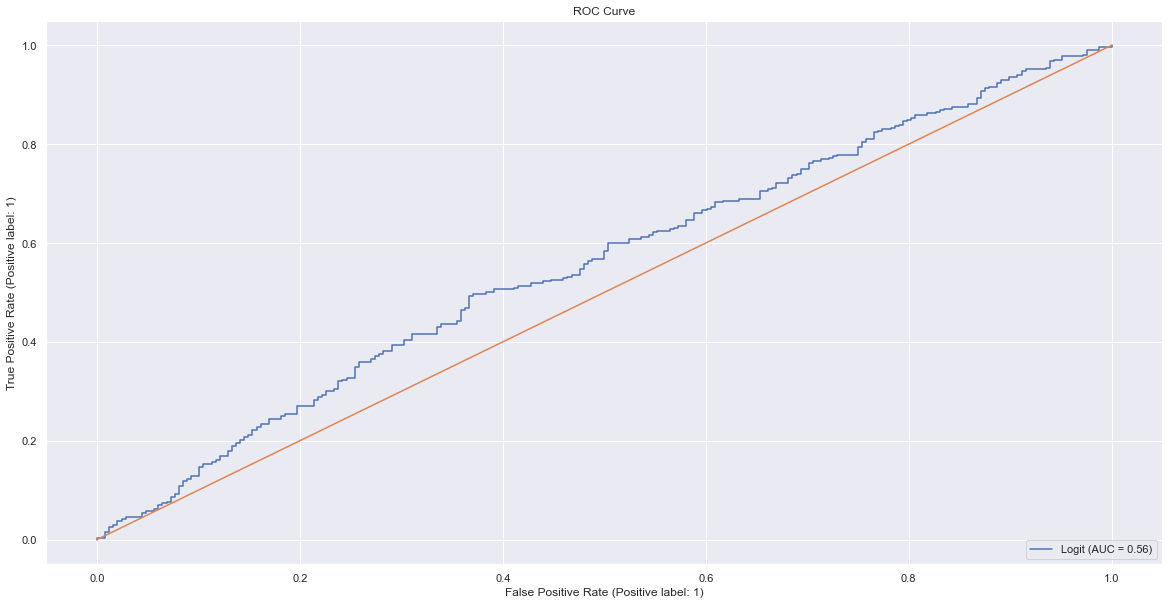

In [318]:
clf = LogisticRegression()
clf.fit(X_train_flat, labels_train)
pred = (clf.predict_proba(X_train_flat)[:,1] > 0.6).astype(int)
print(classification_report(labels_train, pred))

disp_roc = RocCurveDisplay.from_estimator(
        clf, 
        X_train_flat, 
        labels_train,
        name='Logit')
disp_roc.ax_.set_title('ROC Curve')
plt.plot([0,1], [0,1])
plt.show()

In [316]:
clf.predict_proba(X_train_flat)[:,1]

array([0.53961428, 0.53943129, 0.55998472, 0.5613228 , 0.5713512 ,
       0.59533262, 0.61863161, 0.62011635, 0.61427341, 0.61403419,
       0.60801389, 0.5908622 , 0.58199569, 0.57373489, 0.48528696,
       0.52690507, 0.54215208, 0.54506975, 0.53629443, 0.52912963,
       0.52143994, 0.55232024, 0.5604708 , 0.5820573 , 0.59831088,
       0.59201931, 0.55798231, 0.55595096, 0.54755586, 0.55513028,
       0.52445171, 0.52058465, 0.5318802 , 0.57063396, 0.57941982,
       0.59583335, 0.60585034, 0.49683772, 0.47670159, 0.49234456,
       0.46271285, 0.48818369, 0.50262347, 0.5145406 , 0.52619159,
       0.51195573, 0.53394346, 0.54743109, 0.55517814, 0.56902622,
       0.58890742, 0.56567421, 0.59177913, 0.60492796, 0.60657571,
       0.54733833, 0.57341057, 0.58737337, 0.60208412, 0.60490925,
       0.57062392, 0.56278934, 0.55845319, 0.57888795, 0.56287005,
       0.57317952, 0.56614529, 0.56094714, 0.55423354, 0.56267851,
       0.56501027, 0.55741376, 0.56289585, 0.57725708, 0.55797

In [270]:
pnl = clf.predict(X_train_flat)*(y_train_flat.values)
sqrt(12)*np.mean(pnl)/np.std(pnl)
print(np.mean(pnl), np.mean(y_train_flat))

0.4301223380779248 0.3937045110134188


In [276]:
selected_features = [s[:-4] for s in list(X.filter(regex='EUR').columns)]
selected_currencies = ccies
X_train_flat = data_flat(X_train, selected_features, selected_currencies, add_common=True)
X_test_flat = data_flat(X_test, selected_features, selected_currencies, add_common=True)
y_train_flat = pd.Series(y_train[selected_currencies].values.flatten(order='F'))
y_test_flat = pd.Series(y_test[selected_currencies].values.flatten(order='F'))
threshold = 0.5
labels_train = (y_train_flat > threshold).astype(int)
labels_test = (y_test_flat > threshold).astype(int)

In [277]:
fs = SelectKBest(score_func=f_classif)
fit = fs.fit(X_train_flat,labels_train)
features_p = pd.Series(index=X_train_flat.columns, data=fit.pvalues_)
#X_train.drop(features_p[features_p > 0.05].index, axis=1, inplace=True)
features_p.sort_values().head(15)

z_rate_diff_vol        0.046610
spread_realised_ctc    0.101001
spread_realised_par    0.112427
z_VIX Index_all        0.149350
spread_realised_yz     0.163901
spread_realised_gk     0.171158
spread_realised_ewm    0.195680
spread_realised_rs     0.200066
z_realised_ctc         0.228114
z_realised_par         0.280418
z_realised_ewm         0.285043
z_implied_skew         0.306977
z_spot_range           0.311664
z_realised_gk          0.330823
z_realised_rs          0.361108
dtype: float64

In [278]:
features_to_drop = []
features_corr = X_train_flat.corr()
for i in features_corr[(features_corr > 0.9) & (features_corr < 1)].\
unstack().dropna().sort_values(ascending=False).index:
    if features_p[i[0]] > features_p[i[1]]:
        features_to_drop.append(i[0])
    else:
        features_to_drop.append(i[1])

print(features_to_drop)

['z_realised_rs', 'z_realised_rs', 'z_realised_gk', 'z_realised_gk', 'z_realised_yz', 'z_realised_yz', 'z_realised_yz', 'z_realised_yz', 'z_realised_yz', 'z_realised_yz', 'spread_realised_rs', 'spread_realised_rs', 'z_realised_rs', 'z_realised_rs', 'spread_realised_gk', 'spread_realised_gk', 'spread_realised_yz', 'spread_realised_yz', 'spread_realised_gk', 'spread_realised_gk', 'spread_realised_rs', 'spread_realised_rs', 'spread_realised_rs', 'spread_realised_rs', 'z_realised_par', 'z_realised_par', 'z_spot_range', 'z_spot_range', 'z_realised_gk', 'z_realised_gk', 'z_realised_yz', 'z_realised_yz', 'z_realised_ewm', 'z_realised_ewm', 'z_realised_yz', 'z_realised_yz', 'z_realised_rs', 'z_realised_rs', 'z_spot_range', 'z_spot_range']


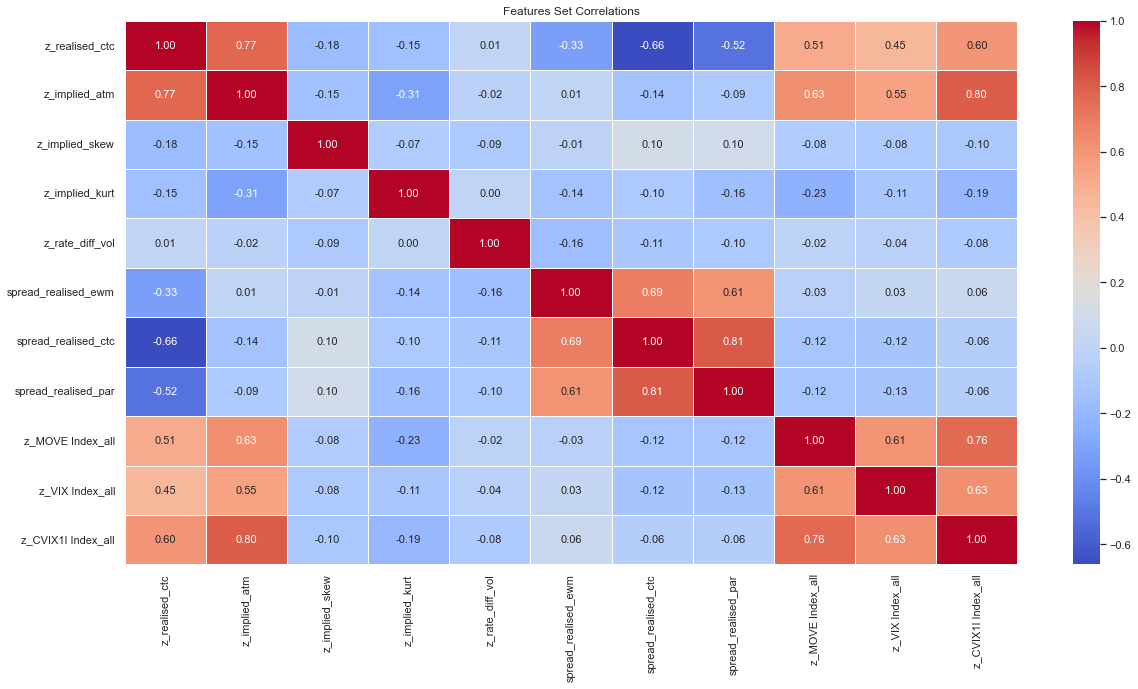

In [279]:
X_train_flat.drop(set(features_to_drop), axis=1, inplace=True)
sns.set(rc={'figure.figsize': (20, 10)})

sns.heatmap(X_train_flat.corr(), 
            annot=True,  
            annot_kws={"size": 11}, 
            fmt=".2f", 
            linewidth=.5, 
            cmap="coolwarm", 
            cbar=True);

plt.title('Features Set Correlations');

In [280]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)
param_grid = {"n_estimators":[10, 100, 500],
              "max_depth":[3, 4, 5, 6, 7, 8, 9, 10],}

fs_model = GridSearchCV(RandomForestClassifier(random_state=42), 
                        param_grid, n_jobs=-1, cv=tscv, scoring='roc_auc')
fs_model.fit(X_train_flat, labels_train)
fs_model.best_params_

{'max_depth': 9, 'n_estimators': 500}

In [281]:
fs_model = RandomForestClassifier(max_depth=9, n_estimators=500, random_state=42)
fs_model.fit(X_train_flat, labels_train)

boruta = BorutaPy(estimator=fs_model, n_estimators = 'auto', random_state=42)
boruta.fit(np.array(X_train_flat), np.array(labels_train))
strong_support = X_train_flat.columns[boruta.support_].to_list()
weak_support = X_train_flat.columns[boruta.support_weak_].to_list()
print('Boruta Strong features:', strong_support)
print('Boruta Weak features:', weak_support)

Boruta Strong features: ['z_rate_diff_vol', 'spread_realised_par', 'z_VIX Index_all', 'z_CVIX1I Index_all']
Boruta Weak features: []


Text(0.5, 1.0, 'Visualizing Important Features')

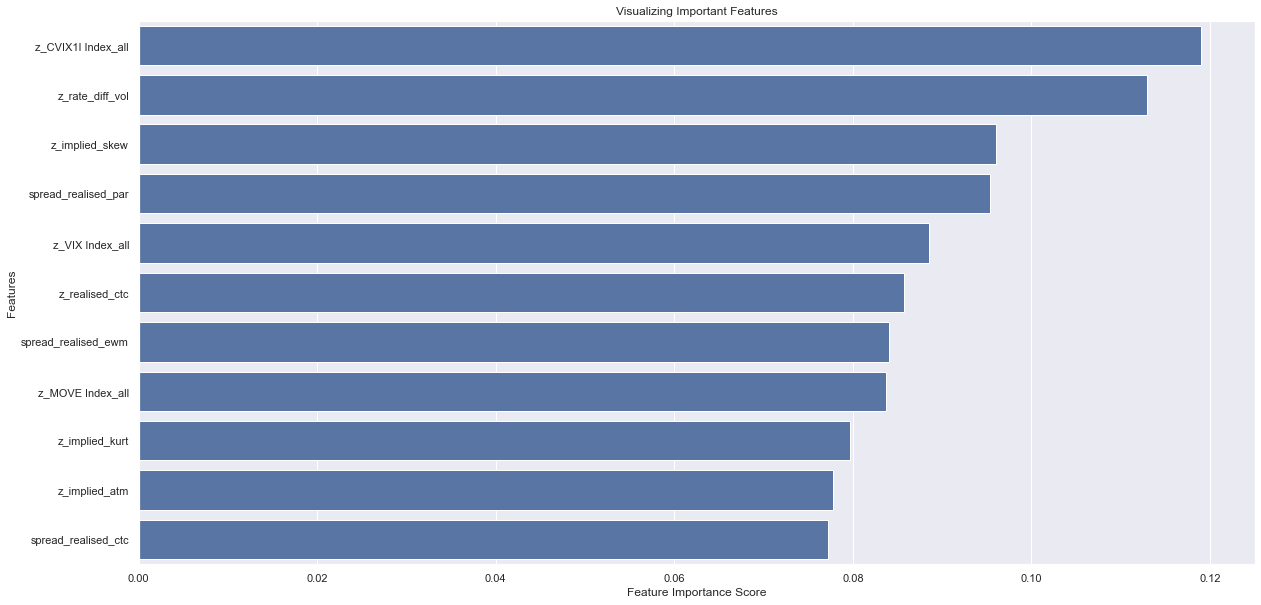

In [282]:
fs_model.fit(X_train_flat, labels_train)
feature_scores = pd.Series(fs_model.feature_importances_, index=X_train_flat.columns).sort_values(ascending=False)
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [135]:
list(feature_scores[feature_scores > 0.1].index)

['z_CVIX1I Index_all',
 'z_MOVE Index_all',
 'z_VIX Index_all',
 'spread_realised_ctc',
 'z_implied_kurt',
 'spread_realised_gk']

In [300]:
selected_features = strong_support + weak_support
#selected_features = list(feature_scores[feature_scores > 0.1].index)
X_train_flat, X_test_flat = X_train_flat[selected_features], X_test_flat[selected_features]

              precision    recall  f1-score   support

           0       0.64      0.21      0.32       248
           1       0.59      0.90      0.71       312

    accuracy                           0.60       560
   macro avg       0.61      0.56      0.52       560
weighted avg       0.61      0.60      0.54       560



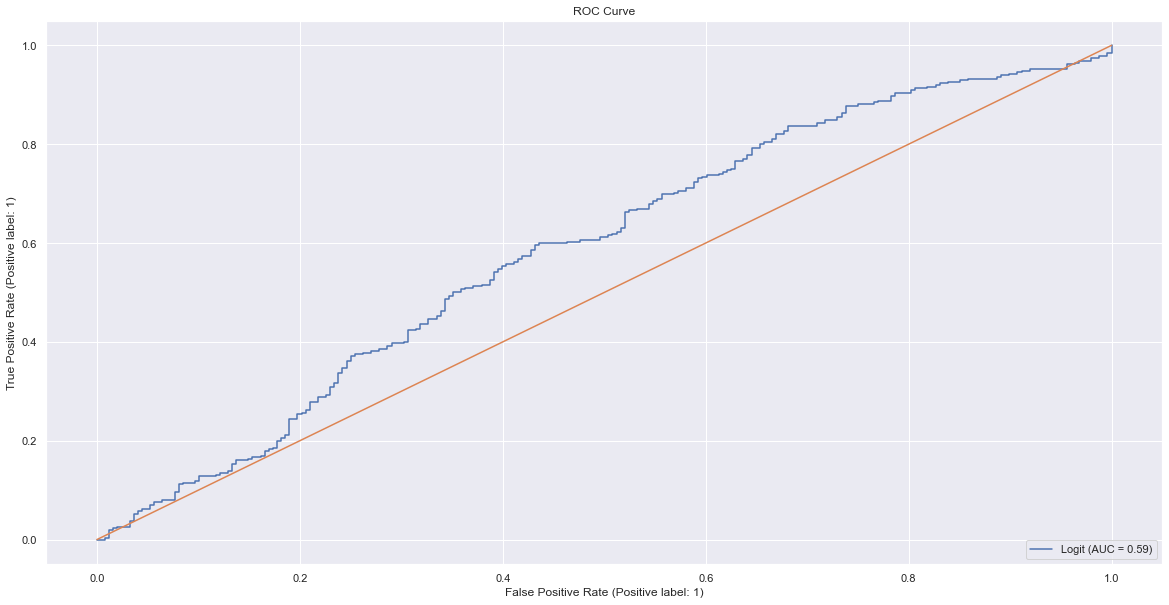

Cross Validation ROC-AUC average: 0.554
Cross Validation ROC-AUC std: 0.046


In [284]:
clf = LogisticRegression()
clf.fit(X_train_flat, labels_train)
print(classification_report(labels_train, clf.predict(X_train_flat)))

disp_roc = RocCurveDisplay.from_estimator(
        clf, 
        X_train_flat, 
        labels_train,
        name='Logit')
disp_roc.ax_.set_title('ROC Curve')
plt.plot([0,1], [0,1])
plt.show()

scores = cross_val_score(clf, X_train_flat, labels_train, n_jobs=-1,
                         scoring='roc_auc', cv=tscv)
print("Cross Validation ROC-AUC average: %.3f" % scores.mean())
print("Cross Validation ROC-AUC std: %.3f" % scores.std())

In [285]:
pnl = clf.predict(X_train_flat)*(y_train_flat.values)
print(sqrt(12)*np.mean(pnl)/np.std(pnl))
print(np.mean(pnl), np.mean(y_train_flat))

0.737174558962248
0.5216034939757329 0.3937045110134188


In [286]:
param_dist = {'n_estimators': scs.randint(50,200),
              'max_depth': scs.randint(1,4)}

rand_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=tscv,
                                 scoring='roc_auc')

rand_search.fit(X_train_flat, labels_train)
rand_search.best_params_

{'max_depth': 3, 'n_estimators': 81}

In [287]:
param_grid = {"n_estimators":[10, 50, 75, 100, 150, 200],
            "max_depth":[2, 3, 4, 5],}

clf_model = GridSearchCV(RandomForestClassifier(random_state=42), 
                        param_grid, n_jobs=-1, cv=tscv, scoring='roc_auc')
clf_model.fit(X_train_flat, labels_train)
clf_model.best_params_

{'max_depth': 5, 'n_estimators': 150}

              precision    recall  f1-score   support

           0       0.72      0.33      0.46       248
           1       0.63      0.89      0.74       312

    accuracy                           0.65       560
   macro avg       0.67      0.61      0.60       560
weighted avg       0.67      0.65      0.61       560



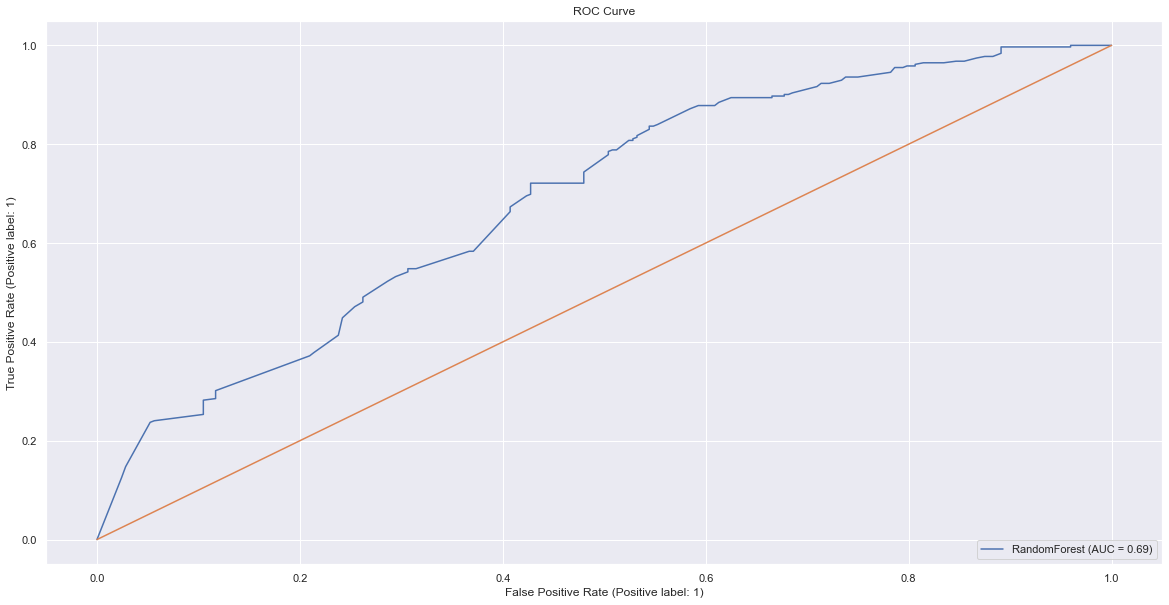

Cross Validation ROC-AUC average: 0.546
Cross Validation ROC-AUC std: 0.072


In [294]:
clf = RandomForestClassifier(max_depth=2, n_estimators=10, random_state=42)
clf.fit(X_train_flat, labels_train)
print(classification_report(labels_train, clf.predict(X_train_flat)))

disp_roc = RocCurveDisplay.from_estimator(
        clf, 
        X_train_flat, 
        labels_train,
        name='RandomForest')
disp_roc.ax_.set_title('ROC Curve')
plt.plot([0,1], [0,1])
plt.show()

scores = cross_val_score(clf, X_train_flat, labels_train, n_jobs=-1,
                         scoring='roc_auc', cv=tscv)
print("Cross Validation ROC-AUC average: %.3f" % scores.mean())
print("Cross Validation ROC-AUC std: %.3f" % scores.std())

In [295]:
pnl = clf.predict(X_train_flat)*(y_train_flat.values)
print(sqrt(12)*np.mean(pnl)/np.std(pnl))
print(np.mean(pnl), np.mean(y_train_flat))

1.0600409037777112
0.670840056107455 0.3937045110134188


In [165]:
for i in range(3):
    tree = clf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train_flat.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [299]:
window = 260 * 2
z_features = rolling_z(raw_features, window=window).add_prefix('z_')
X = z_features.merge(rolling_z(spreads,window=window, standardize=False), on='date').dropna()
idx = (X.index).intersection(y.index)
X, y = X.loc[idx], y.loc[idx]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

selected_features = [s[:-4] for s in list(X.filter(regex='EUR').columns)]
selected_currencies = ccies
X_train_flat = data_flat(X_train, selected_features, selected_currencies, add_common=True)
X_test_flat = data_flat(X_test, selected_features, selected_currencies, add_common=True)
y_train_flat = pd.Series(y_train[selected_currencies].values.flatten(order='F'))
y_test_flat = pd.Series(y_test[selected_currencies].values.flatten(order='F'))
threshold = 0.5
labels_train = (y_train_flat > threshold).astype(int)
labels_test = (y_test_flat > threshold).astype(int)


In [306]:
pipeline_cv = Pipeline([
    ('svm', SVC())  # SVM classifier
])
param_grid_svm = [ {'svm__C':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 100, 125, 150, 175, 200],
                    'svm__kernel':['linear']},
                  {'svm__C':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 100, 125, 150, 175, 200],
                   'svm__kernel':['rbf'],
                   'svm__gamma':["scale", "auto", 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]}]
grid_search = GridSearchCV(pipeline_cv, param_grid_svm, n_jobs=-1, cv=tscv, scoring='roc_auc')
grid_search.fit(X_train_flat, labels_train)
grid_search.best_params_

{'svm__C': 175, 'svm__kernel': 'linear'}

In [307]:
pipeline = Pipeline([  # Preprocessing step: Standardization
    ('svm', SVC(C=175, kernel='linear'))  # SVM classifier
])

pipeline.fit(X_train_flat, labels_train)

print ("Train Set ROC-AUC Score: %.3f" % roc_auc_score(labels_train, pipeline.predict(X_train_flat)))
print(classification_report(labels_train, pipeline.predict(X_train_flat)))
scores = cross_val_score(pipeline, X_train_flat, labels_train, n_jobs=-1,
                         scoring='roc_auc', cv=tscv)
print("Cross Validation ROC-AUC average: %.3f" % scores.mean())
print("Cross Validation ROC-AUC average: %.3f" % scores.std())

Train Set ROC-AUC Score: 0.500
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       248
           1       0.56      1.00      0.72       312

    accuracy                           0.56       560
   macro avg       0.28      0.50      0.36       560
weighted avg       0.31      0.56      0.40       560

Cross Validation ROC-AUC average: 0.536
Cross Validation ROC-AUC average: 0.035


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [336]:
raw_features.rolling(window=window, min_periods=window).rank(pct=True)['realised_ewm_EUR'].iplot()